In [14]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()

In [4]:
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [7]:
# build the vocab of chars and mapping to/from int
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [8]:
# build the dataset

block_size = 3 # context length: how many chars do we take to predict the next one?
X, Y = [], []

for w in words[:5]:
    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X, device='cuda')
Y = torch.tensor(Y, device='cuda')

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [9]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [10]:
C = torch.randn((27, 2), device='cuda')

In [12]:
C[5]

tensor([0.0051, 1.4861], device='cuda:0')

In [16]:
F.one_hot(torch.tensor(5, device='cuda'), num_classes=27).float() @ C

tensor([0.0051, 1.4861], device='cuda:0')

In [19]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [51]:
W1 = torch.randn((6, 100), device='cuda')
b1 = torch.randn(100, device='cuda')

In [34]:
# emb @ W + b, but dim don't match
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

torch.Size([32, 6])

In [35]:
torch.cat(torch.unbind(emb, 1), 1).shape # generalized for above

torch.Size([32, 6])

In [37]:
a = torch.arange(18, device='cuda')
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17],
       device='cuda:0')

In [38]:
a.shape

torch.Size([18])

In [43]:
a.view(3, 3, 2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]], device='cuda:0')

In [45]:
a.storage()

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cuda:0) of size 18]

In [48]:
 emb.view(32, 6)

tensor([[ 1.1271, -0.6878,  1.1271, -0.6878,  1.1271, -0.6878],
        [ 1.1271, -0.6878,  1.1271, -0.6878,  0.0051,  1.4861],
        [ 1.1271, -0.6878,  0.0051,  1.4861, -0.6919,  1.3322],
        [ 0.0051,  1.4861, -0.6919,  1.3322, -0.6919,  1.3322],
        [-0.6919,  1.3322, -0.6919,  1.3322,  0.9791, -0.0715],
        [ 1.1271, -0.6878,  1.1271, -0.6878,  1.1271, -0.6878],
        [ 1.1271, -0.6878,  1.1271, -0.6878,  0.2956, -1.1154],
        [ 1.1271, -0.6878,  0.2956, -1.1154, -0.9406,  1.4171],
        [ 0.2956, -1.1154, -0.9406,  1.4171, -0.6331, -1.8774],
        [-0.9406,  1.4171, -0.6331, -1.8774,  0.4849,  0.1420],
        [-0.6331, -1.8774,  0.4849,  0.1420, -0.6331, -1.8774],
        [ 0.4849,  0.1420, -0.6331, -1.8774,  0.9791, -0.0715],
        [ 1.1271, -0.6878,  1.1271, -0.6878,  1.1271, -0.6878],
        [ 1.1271, -0.6878,  1.1271, -0.6878,  0.9791, -0.0715],
        [ 1.1271, -0.6878,  0.9791, -0.0715,  0.4849,  0.1420],
        [ 0.9791, -0.0715,  0.4849,  0.1

In [60]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # can use -1 to infer emb.shape[0]
h

tensor([[-0.9309,  0.8924,  0.9993,  ...,  0.9628,  0.9594,  0.9999],
        [-0.2743,  0.9989,  0.9983,  ..., -0.9006,  0.7623, -0.4142],
        [ 0.9570,  0.8330, -0.9950,  ..., -0.8651, -0.9986, -0.9828],
        ...,
        [-0.8025,  0.9781,  0.9857,  ...,  0.7301,  0.7362,  0.9744],
        [ 0.9498, -0.9499,  0.2467,  ...,  0.9999,  0.7738,  0.9999],
        [-0.9951,  0.9971,  0.9959,  ...,  0.1842, -0.0278,  0.9332]],
       device='cuda:0')

In [61]:
h.shape

torch.Size([32, 100])

In [62]:
W2 = torch.randn((100, 27), device='cuda')
b2 = torch.randn(27, device='cuda')
logits = h @ W2 + b2

In [63]:
logits.shape

torch.Size([32, 27])

In [64]:
logits

tensor([[-6.6719e+00,  6.6125e+00,  3.6613e+00,  5.7366e+00, -8.3992e+00,
          1.2754e+01, -4.8224e+00, -1.9450e+00,  4.8050e+00, -1.5074e+01,
          6.0426e+00,  3.1692e-01,  6.4591e+00, -5.0825e+00,  3.3265e+00,
         -4.2947e+00, -3.7920e+00, -1.8168e+01, -7.9236e+00,  1.4333e+01,
         -2.9633e-01, -4.2638e+00,  3.7132e+00, -5.6492e+00, -1.5753e+01,
         -3.9476e+00,  3.3354e+00],
        [-1.5676e+01,  4.7888e-01, -2.2930e-01,  4.4010e+00, -6.7793e+00,
          2.3616e+00,  1.2145e+01, -3.5919e+00,  1.4268e+01, -6.8665e+00,
          3.5585e+00, -4.3332e+00,  1.3291e+01, -9.3085e+00,  3.4333e-01,
          6.6902e+00, -6.1626e+00, -8.7005e+00, -9.4241e-02,  2.0293e+01,
          2.6147e+00,  2.1815e-01,  1.3743e+01,  7.3696e+00,  9.5027e+00,
         -1.7705e+00, -6.6780e-01],
        [-6.2234e+00, -7.4386e+00,  4.2270e+00, -5.0066e+00, -8.6801e+00,
         -1.0049e+01,  2.1006e+00, -2.9581e+00,  2.4663e+00, -1.2156e+00,
         -6.9667e+00,  2.0539e+00,  5.10

In [65]:
counts = logits.exp()

In [66]:
prob = counts / counts.sum(1, keepdims=True)

In [71]:
 torch.arange(32)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [70]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0],
       device='cuda:0')

In [73]:
prob[torch.arange(32), Y]

tensor([1.7079e-01, 1.3865e-13, 2.4548e-07, 8.5249e-14, 1.1357e-09, 6.7323e-09,
        4.4954e-04, 4.1673e-10, 5.3502e-09, 5.8686e-09, 1.9707e-06, 1.0411e-14,
        3.6734e-04, 2.9492e-06, 9.7562e-05, 4.5939e-13, 1.4023e-13, 1.6566e-03,
        2.2739e-10, 1.6695e-09, 1.5307e-09, 7.0776e-10, 3.0304e-10, 4.7374e-14,
        6.6092e-10, 8.2804e-01, 1.0770e-09, 5.4678e-10, 6.9085e-05, 9.3055e-19,
        1.8787e-05, 5.3506e-15], device='cuda:0')

In [77]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(19.2984, device='cuda:0')

In [78]:
# now implementing it properly with all the pieces in place

In [79]:
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [168]:
g = torch.Generator(device='cuda').manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g, device='cuda')
W1 = torch.randn((30, 200), generator=g, device='cuda')
b1 = torch.randn(200, generator=g, device='cuda')
W2 = torch.randn((200, 27), generator=g, device='cuda')
b2 = torch.randn(27, generator=g, device='cuda')
parameters = [C, W1, b1, W2, b2]

In [169]:
sum(p.nelement() for p in parameters)

11897

In [170]:
for p in parameters:
    p.requires_grad = True

In [142]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [175]:
lri = []
lossi = []
stepi = []

In [178]:
for i in range(50000):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (32,), device='cuda')
    
    # forward pass
    emb = C[Xtr[ix]] # 32, 3, 2
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # 32 100
    logits = h @ W2 + b2 # 32 27
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 10 ** -2 # lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    # lossi.append(loss.item())
    stepi.append(i)
    lossi.append(loss.log10().item())

print(loss.item())

1.9217445850372314


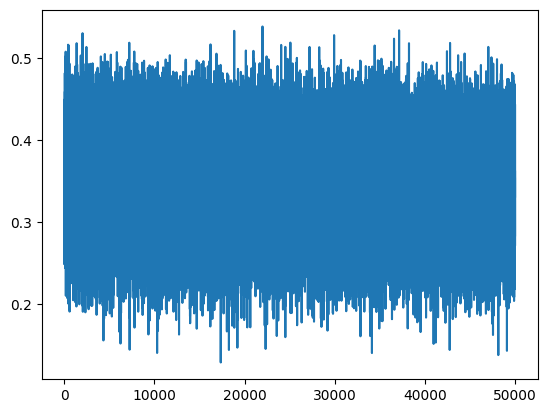

In [181]:
plt.plot(stepi, lossi)

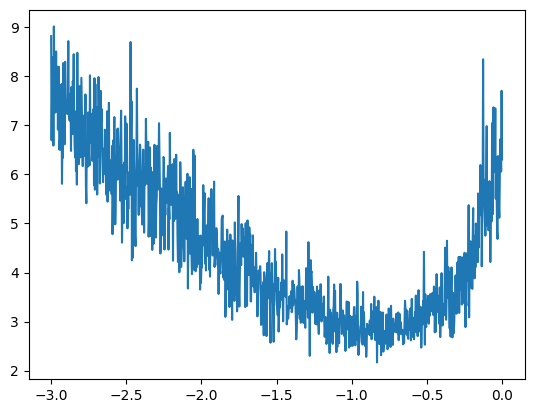

In [127]:
plt.plot(lri, lossi)

In [100]:
# build the dataset

block_size = 3 # context length: how many chars do we take to predict the next one?
X, Y = [], []

for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X, device='cuda')
Y = torch.tensor(Y, device='cuda')

In [102]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [137]:
# training split, dev/ validation split, test split
# 80%, 10%, 10%

def build_dataset(words):
    block_size = 3 # context length
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X, device='cuda')
    Y = torch.tensor(Y, device='cuda')
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [138]:
C = torch.randn((27, 2), device='cuda')

In [179]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # 32, 100
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1859, device='cuda:0', grad_fn=<NllLossBackward0>)

In [180]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # 32, 100
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1322, device='cuda:0', grad_fn=<NllLossBackward0>)

In [151]:
# Sincde training and dev loss are very close we are not overfitting, perhaps even underfitting suggesting small network
# updating neurons from 100 -> 300
# still little improvement maybe the emb size 2 is the bottleneck? let's try 10

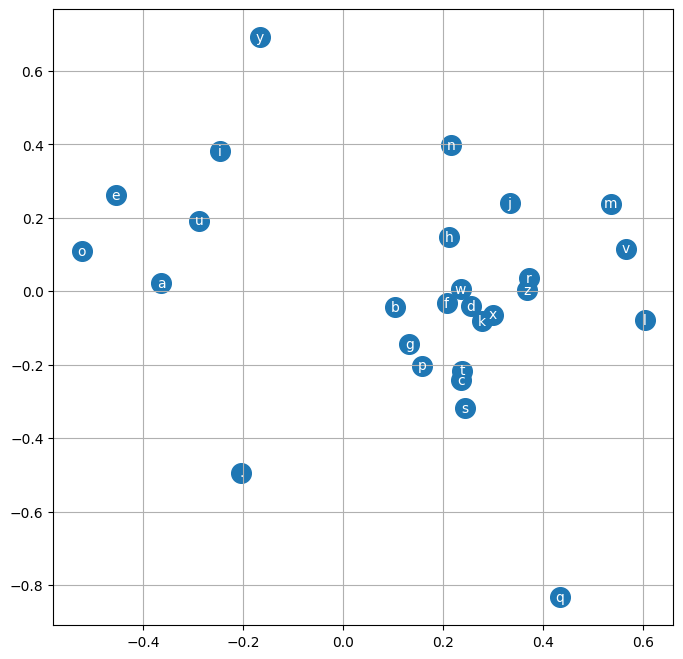

In [167]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:,0].to('cpu').data, C[:,1].to('cpu').data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

In [182]:
# meta/ hyper parameters -> context size, embedding space, neurons in hidden layer, learning rate/ decay rate, no. of iters

In [187]:
# sample from the model
g = torch.Generator(device='cuda').manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context], device='cuda')] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context [1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))


bree.
sah.
zemade.
ralynn.
hardrone.
breidenoverle.
emin.
jagruf.
gewuttissi.
met.
tarelynn.
aarstte.
tjuse.
gendy.
marah.
aan.
jurlana.
dorge.
aviel.
mikhellowas.
